In [ ]:
## Write an introductory docstring here.

In [5]:
# Import modules
import numpy as np
import netCDF4 as nc
import xarray as xr
from datetime import datetime
import matplotlib.dates as dt
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

In [6]:
#=============NCDump Function==================================================

# Adapted from Chris Slocum (http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html)
 
# Modified October, 2018 by Nick Grosfeld:
#   - Updated for Python 3 (added parentheses for each call to 'print');
#   - Changed the input parameter nc_fid from a python netcdf object to a string of the path to a netcdf file;     
#   - Added an option to close the netcdf file after opening.

'''
NAME
    NetCDF with Python
PURPOSE
    To demonstrate how to read and write data with NetCDF files using
    a NetCDF file from the NCEP/NCAR Reanalysis.
    Plotting using Matplotlib and Basemap is also shown.
PROGRAMMER(S)
    Chris Slocum
REVISION HISTORY
    20140320 -- Initial version created and posted online
    20140722 -- Added basic error handling to ncdump
                Thanks to K.-Michael Aye for highlighting the issue
REFERENCES
    netcdf4-python -- http://code.google.com/p/netcdf4-python/
    NCEP/NCAR Reanalysis -- Kalnay et al. 1996
        http://dx.doi.org/10.1175/1520-0477(1996)077<0437:TNYRP>2.0.CO;2
'''

def ncdump(file_path, verb = True, close_file = True):
    
    nc_obj = nc.Dataset(file_path, 'r', format = 'NETCDF4')
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print ("\t\ttype:", repr(nc_obj.variables[key].dtype))
            for ncattr in nc_obj.variables[key].ncattrs():
                print ('\t\t%s:' % ncattr,\
                      repr(nc_obj.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_obj.ncattrs()
    if verb:
        print ("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print ('\t%s:' % nc_attr, repr(nc_obj.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_obj.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print ("NetCDF dimension information:")
        for dim in nc_dims:
            print ("\tName:", dim )
            print ("\t\tsize:", len(nc_obj.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_obj.variables]  # list of nc variables
    if verb:
        print ("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print ('\tName:', var)
                print ("\t\tdimensions:", nc_obj.variables[var].dimensions)
                print ("\t\tsize:", nc_obj.variables[var].size)
                print_ncattr(var)
                
    if close_file:
        nc_obj.close()
        
    return nc_attrs, nc_dims, nc_vars

In [7]:
# define a function to view the contents of a file.

def view_file_contents(file_path, file_name):
    
    ''' This function prints information about the file of data at a given file path. 
    
    Inputs
    -------
    filepath: string. The absolute directory location of the data being viewed. 
    filename: string. The file name of the data being viewed. 
    
    Output
    -------
    printed to standard output.'''
    
    ds_fromfile = xr.open_dataset(file_path + file_name) # opens the file as an Xarray dataset
    print(ds_fromfile) # prints the information to the screen
    
    ds_fromfile.close() # close the dataset object for good form.
    return

# define a function to open a netcdf file and return an xarray data_array. Create an option to show a print out of 
# the metadata. 

def dataarray_from_file(file_path, file_name, var_name, show_metadata = False, close_dataset = True):
    
    ''' This function opens a data file at a given file path, and extracts and returns an Xarray dataarray object
     for a given variable name. It includes options to display some metadata about the extracted dataarray, as well
     as an option to close the data file object afterwards.
     
    Inputs
    -------
    filepath: string. The absolute directory location of the data veing opened. 
    filename: string. The file name of the data being opened. 
    var_name: string. The name of the variable that you wish to open a dataattay of. 
    
    show_metadata: boolean. Option to view some metadata information printed to the screen.
    close_dataset: boolean. Option to close the file after the dataarray is extracted. 
    
    Output
    -------
    da: Xarray dataarray.'''
    
    ds_fromfile = xr.open_dataset(file_path + file_name) # opens the file as an Xarray dataset
    da = ds_fromfile[var_name] # extracts the dataarray containing the variable from the dataset
    
    if show_metadata:
        print(da) # prints the information to the screen
        
    if close_dataset:
        ds_fromfile.close() # close the dataset object for good form.
        
    return da

# define a function to extract a 2d field of data from a dataarray. 

def extract_2d_field(data_array, lats, lons, y, m, d, h):
    
    '''' This function extracts a field of data within a set of latitude and longitude limits at a given timestep 
    from an Xarray dataarray object, and returns the field of data as a numpy array. 
    
    Inputs
    -------
    data_array: Xarray dataarray object. 
    
    lats: tuple (of floats). The minimum and maximum latitude values of your region to extract, e.g. (122.5, 150.0)
    lons: tuple (of floats). The minimum and maximum longitude values of your region to extract, e.g. (-30, -47.5)
    
    y,m,d,h: integers. The year, month, day, and hour you wish to extract the data for. 
    
    Output
    -------
    field_array.data: numpy array.
    '''
    
    # extract the data variable from the dataarray
    field_array = data_array.sel(lon = slice(lons[0], lons[1]), lat = slice(lats[0], lats[1]), time = datetime(y,m,d,h))
    
    return field_array.data

def extract_2d_array(data_array, lats, lons, y, m, d, h):
    
    '''' This function takes a subset of data within a set of latitude and longitude limits at a given timestep 
    from an Xarray dataarray object, and returns the field of data as an Xarray dataarray.
    
    Inputs
    -------
    data_array: Xarray dataarray object. 
    
    lats: tuple (of floats). The minimum and maximum latitude values of your region to extract, e.g. (122.5, 150.0)
    lons: tuple (of floats). The minimum and maximum longitude values of your region to extract, e.g. (-30, -47.5)
    
    y,m,d,h: integers. The year, month, day, and hour you wish to extract the data for. 
    
    Output
    -------
    field_array: Xarray dataarray.
    '''
    
    # extract the data variable from the dataarray
    field_array = data_array.sel(lon = slice(lons[0], lons[1]), lat = slice(lats[0], lats[1]), time = datetime(y,m,d,h))
    
    return field_array

# do another function here for computing thickness

def compute_thickness_field(data_array, lats, lons, y, m, d, h, level_upper, level_lower):
    
    '''' This function extracts a field of data within a set of latitude and longitude limits at a given timestep 
    for two different levels from an Xarray dataarray object, computes the difference in values between the two
    arrays, and returns the field of data as a numpy array. 
    
    Inputs
    -------
    data_array: Xarray dataarray object. 
    
    lats: tuple (of floats). The minimum and maximum latitude values of your region to extract, e.g. (122.5, 150.0)
    lons: tuple (of floats). The minimum and maximum longitude values of your region to extract, e.g. (-30, -47.5)
    
    y,m,d,h: integers. The year, month, day, and hour you wish to extract the data for. 
    
    level_upper: integer. The height coordinate of the upper level for the thickness computation. 
    level_lower: integer. The height coordinate of the lower level for the thickness computation.
    
    Output
    -------
    field_array_thick.data: numpy array.
    
    '''
    
    # extract the data variable for both upper and lower levels from the dataarray
    field_array_upper = data_array.sel(lon = slice(lons[0], lons[1]), lat = slice(lats[0], lats[1]), time = datetime(y,m,d,h), level = level_upper)
    field_array_lower = data_array.sel(lon = slice(lons[0], lons[1]), lat = slice(lats[0], lats[1]), time = datetime(y,m,d,h), level = level_lower)
    
    # compute the difference of the arrays
    field_array_thick = field_array_upper - field_array_lower
    
    return field_array_thick.data

def compute_thickness_array(data_array, lats, lons, y, m, d, h, level_upper, level_lower):
    
    '''' This function extracts a field of data within a set of latitude and longitude limits at a given timestep 
    for two different levels from an Xarray dataarray object, computes the difference in values between the two
    arrays, and returns the field of data as a numpy array.
    
    Inputs
    -------
    data_array: Xarray dataarray object. 
    
    lats: tuple (of floats). The minimum and maximum latitude values of your region to extract, e.g. (122.5, 150.0)
    lons: tuple (of floats). The minimum and maximum longitude values of your region to extract, e.g. (-30, -47.5)
    
    y,m,d,h: integers. The year, month, day, and hour you wish to extract the data for. 
    
    level_upper: integer. The height coordinate of the upper level for the thickness computation. 
    level_lower: integer. The height coordinate of the lower level for the thickness computation.
    
    Output
    -------
    field_array_thick: Xarray dataarray.'''
    
    # extract the data variable for both upper and lower levels from the dataarray
    field_array_upper = data_array.sel(lon = slice(lons[0], lons[1]), lat = slice(lats[0], lats[1]), time = datetime(y,m,d,h), level = level_upper)
    field_array_lower = data_array.sel(lon = slice(lons[0], lons[1]), lat = slice(lats[0], lats[1]), time = datetime(y,m,d,h), level = level_lower)
    
    # compute the difference of the arrays
    field_array_thick = field_array_upper - field_array_lower
    
    return field_array_thick

# do a plotting function here

def plot_field_contour(array, res, lats, lons, map_underlay = False, savefigure = False, file_name = None, show_plot = True):
    
    ''''
    This function creates a contour plot of a 2 dimensional array of numerical data, ideally representing a 
    geographical region. It contains options to include a map with the plot, save the plot to file, and/or display
    the plot on the screen after.
    
    Inputs
    -------
    
    array: Xarray dataarray. An object containing the 2d field of data to plot, as well as lat and lon axis vectors.
    res: float. The spatial resolution of the data being plotted. 
    
    lats: tuple (of floats). The minimum and maximum latitude values of your region to plot, e.g. (122.5, 150.0)
    lons: tuple (of floats). The minimum and maximum longitude values of your region to plot, e.g. (-30, -47.5)
    
    map_underlay: boolean. An option to include a map (from basemap) under the contour plot.
    savefigure: boolean. An option to save the plot as an image. 
    file_name: string. file_path/file_name.extension (e.g. '/Users/Nick/Documents/Climate/fig_01.png')
    show_plot: boolean. An option to display the plot on the screen after. 
    
    Outputs
    -------
    
    Outputs either a graphic file to disk, or a plot on the screen. 
    '''
    # set up 2d arrays of latitude and longitude coordinates to give the location of the array data for the contour
    # plot.
    lat_vector = array['lat'] # m * 1 array of latitude values
    lon_vector = array['lon'] # n * 1 array of longitude values
    
    latall = np.meshgrid(lon_vector, lat_vector)[1] # m * 1 * n * 1 ---> m * n array of latitude values
    lonall = np.meshgrid(lon_vector, lat_vector)[0] # m * 1 * n * 1 ---> m * n array of longitude values
    
    def add_map_underlay():
        
        # This part overlays a map
        mapproj = bm.Basemap(projection = 'cyl',llcrnrlat = lats[1],llcrnrlon = lons[0],urcrnrlat = lats[0],urcrnrlon = lons[1])
        mapproj.drawcoastlines()
        mapproj.drawparallels(lats, labels = [1,0,0,0],fontsize = 10, linewidth = 0) # Show the longitude scale, but hide the lines.
        mapproj.drawmeridians(lons, labels = [0,0,0,1],fontsize = 10, rotation = 'vertical', linewidth = 0) # Show the latitude scale, but hide the lines.
    
    # create the plot object with a contour graph of x, y, data(x, y). 
    graphic = plt.contour(lonall, latall, array.data, 20, colors = 'k')
    
    # customise the contour label properties
    plt.clabel(graphic, fontsize = 12)
    
    if map_underlay:
        
       add_map_underlay() 
    
    #- Call show and savefig:
    if savefigure:
        
        plt.savefig(file_name)
        
    if show_plot:
        
        plt.show()
        
    plt.close('all')
    
    return
    
def plot_contour_colour(contour_array, colour_array, res, lats, lons, size = (6,8), map_underlay = False, gridres = 5, savefigure = False, file_name = None, show_plot = True):
    
    '''
    This function creates a contour plot of two 2-dimensional arrays of numerical data, one of which will be shown
    as contour lines, and the other as colours beneith the contours, ideally representing a geographical region. It
    contains options to include a map with the plot, save the plot to file, and/or display the plot on the screen 
    after.
    
    Inputs
    -------
    
    contour_array: Xarray dataarray. An object containing the 2d field of data to plot as contour lines, as well as
                lat and lon axis vectors.
    colour_array: Xarray dataarray. An object containing the 2d field of data to plot as colours, as well as lat 
                and lon axis vectors.            
    res: float. The spatial resolution of the data being plotted. 
    
    lats: tuple (of floats). The minimum and maximum latitude values of your region to plot, e.g. (122.5, 150.0)
    lons: tuple (of floats). The minimum and maximum longitude values of your region to plot, e.g. (-30, -47.5)
    
    map_underlay: boolean. An option to include a map (from basemap) under the contour plot.
    savefigure: boolean. An option to save the plot as an image. 
    file_name: string. file_path/file_name.extension (e.g. '/Users/Nick/Documents/Climate/fig_01.png')
    show_plot: boolean. An option to display the plot on the screen after. 
    
    Outputs
    -------
    
    Outputs either a graphic file to disk, or a plot on the screen. 
    '''
    # set up 2d arrays of latitude and longitude coordinates to give the location of the array data for the contour
    # plot.
    lat_vector = contour_array['lat'] # m * 1 array of latitude values
    lon_vector = contour_array['lon'] # n * 1 array of longitude values
    
    latall = np.meshgrid(lon_vector, lat_vector)[1] # m * 1 * n * 1 ---> m * n array of latitude values
    lonall = np.meshgrid(lon_vector, lat_vector)[0] # m * 1 * n * 1 ---> m * n array of longitude values
    
    def add_map_underlay():
        
        # This part overlays a map
        mapproj = bm.Basemap(projection = 'cyl',llcrnrlat = lats[1],llcrnrlon = lons[0],urcrnrlat = lats[0],urcrnrlon = lons[1])
        mapproj.drawcoastlines()
        
        lat_gridlines = np.arange(lats[0], lats[1] - gridres, -1 * gridres)
        lon_gridlines = np.arange(lons[0], lons[1] + gridres, gridres)
        
        mapproj.drawparallels(lat_gridlines, labels = [1,0,0,0],fontsize = 10, linewidth = 0) # Show the longitude scale, but hide the lines.
        mapproj.drawmeridians(lon_gridlines, labels = [0,0,0,1],fontsize = 10, rotation = 'vertical', linewidth = 0) # Show the latitude scale, but hide the lines.
    
    # create the plot object with a contour and filled-contour graphs of x, y, data(x, y). 
    fig = plt.figure(figsize = size )   
    contour_layer = plt.contour(lonall, latall, contour_array.data, 10, colors = 'k')
    colour_layer = plt.contourf(lonall, latall, colour_array.data, 10)
    
    # customise the contour label properties
    plt.clabel(contour_layer, fontsize = 12)
    
    # add a colour scale for the colour data
    plt.colorbar(colour_layer, orientation = 'horizontal')
    
    if map_underlay:
        
       add_map_underlay() 
    
    #- Call show and savefig:
    if savefigure:
        
        plt.savefig(file_name)
        
    if show_plot:
        
        plt.show()
        
    plt.close('all')
    
    return

In [8]:
# This code just sets up variables relevant to my own particular datasets and file structure, to make calling 
# the above functions easier. 

dataset = 'ncep1'

if dataset == 'eraint':
    
    # variables for the file name
    data_path = '/Volumes/ExternalHD/Large_Data/ERA-Interim/Regridded/'
    hgt_file_prefix = 'z500.'
    slp_file_prefix = 'slp.'
    file_extension = '_rgd.nc'
    
    p_level = 50000

    time_y0 = 1900
    
    # dimension and axis names inside the file
    lat_variable_name = 'lat'
    lon_variable_name = 'lon'
    vertical_coordinate_name = 'lev' # 'level' for NCEP1, 'lev' for ERAInterim
    time_variable_name = 'time'
    gph_variable_name = 'z' # 'hgt' for NCEP1, 'z' for ERAInterim
    slp_variable_name = 'psl'
    
elif dataset == 'ncep1':
    
    # variables for the file name
    data_path = '/Volumes/ExternalHD/Large_Data/NCEP1/'
    hgt_file_prefix = 'hgt.'
    slp_file_prefix = 'slp.'
    file_extension = '.nc'
    
    p_level = 500

    time_y0 = 1800
    
    # dimension and axis names inside the file
    lat_variable_name = 'lat'
    lon_variable_name = 'lon'
    vertical_coordinate_name = 'level' # 'level' for NCEP1, 'lev' for ERAInterim
    time_variable_name = 'time'
    gph_variable_name = 'hgt' # 'hgt' for NCEP1, 'z' for ERAInterim
    slp_variable_name = 'slp'

In [16]:
hgt_da = dataarray_from_file(data_path, hgt_file_prefix + str(1980) + file_extension, gph_variable_name)
slp_da = dataarray_from_file(data_path, slp_file_prefix + str(1980) + file_extension, slp_variable_name)

thick_array = compute_thickness_array(hgt_da, (-30, -45), (125, 150), 1980, 12, 31, 0, 500, 1000)
slp_array = extract_2d_array(slp_da, (-30, -45), (125, 150), 1980, 12, 31, 0)

In [17]:
print(thick_array)

<xarray.DataArray 'hgt' (lat: 7, lon: 11)>
array([[5794., 5800., 5802., 5799., 5797., 5790., 5773., 5741., 5702.,
        5670., 5656.],
       [5747., 5767., 5781., 5791., 5796., 5794., 5783., 5758., 5726.,
        5695., 5674.],
       [5682., 5712., 5737., 5756., 5769., 5776., 5774., 5761., 5739.,
        5713., 5690.],
       [5604., 5639., 5670., 5696., 5717., 5732., 5740., 5739., 5727.,
        5710., 5691.],
       [5529., 5563., 5596., 5625., 5649., 5669., 5682., 5689., 5686.,
        5679., 5671.],
       [5469., 5496., 5527., 5556., 5581., 5601., 5616., 5625., 5629.,
        5630., 5633.],
       [5423., 5442., 5468., 5494., 5518., 5537., 5552., 5562., 5570.,
        5579., 5590.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -30.0 -32.5 -35.0 -37.5 -40.0 -42.5 -45.0
  * lon      (lon) float32 125.0 127.5 130.0 132.5 ... 142.5 145.0 147.5 150.0
    time     datetime64[ns] 1980-12-31


/Users/nick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:276: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


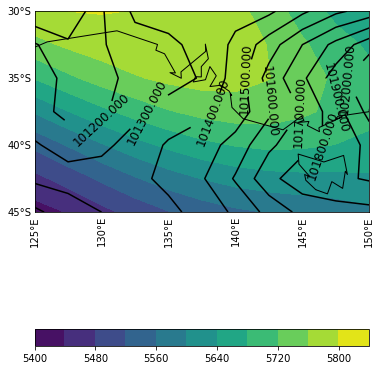

In [18]:
plot_contour_colour(slp_array, thick_array, 2.5, (-30, -45), (125, 150), map_underlay = True, savefigure = False, file_name = None, show_plot = True)
